In [26]:
import sys
import os
import cv2
import random
import itertools
import shutil
import glob
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
import seaborn as sn
import regex as re
from skimage  import io
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte, img_as_float
from scipy import ndimage as nd
from PIL import Image
import plotly
import tensorflow.keras
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model ,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization,Input,add,Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate 
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from sklearn.metrics import plot_confusion_matrix, roc_curve, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
%matplotlib inline

# splitting the letters into different folders for filtering

In [22]:
imagefile_path = "Cleaned letter images 1"
os.chdir(imagefile_path)
arabic_characters = {1:"Alef", 2:"Baa", 3:"Taa", 4:"Thaa", 5:"Jeem", 6:"H'aa", 
                     7:"Khaa", 8:"Daal", 9:"Thaal", 10:"Raa", 11:"Zaay", 12:"Seen", 
                     13:"Sheen", 14:"Saad", 15:"Daad", 16:"T'aa", 17:"Dhaa", 18:"Ayn", 
                     19:"Ghayn", 20:"Faa", 21:"Qaaf", 22:"Kaaf", 23:"Laam", 24:"Meem", 
                     25:"Noon", 26:"Haa", 27:"Waaw", 28:"Yaa"}

# create folders with arabic_characters names
for key, value in arabic_characters.items():
    if os.path.isdir(value) is False:
        os.makedirs(value)

# move each character to its folder
for i in random.sample(glob.glob('square_-image-*'), 8900):
    for key, value in arabic_characters.items():
        if ('-' + str(key) + '-') in img:
            shutil.move(i, value)

os.chdir('../../')

C:\Users\MOneb\anaconda3\envs\ev_2\lib\site-packages\ipykernel_launcher.py:17: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



# Extracting the training images as CSV

In [ ]:
dataset_folder = 'AIA9K images after cleaning'
os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)

os.chdir('../../')

X = np.array(X).reshape(-1,1024)

df = pd.DataFrame(X)

df.to_csv('AIA9KtrainingImagesCleaned.csv',index=False, header=False)

# Extracting the training labels as CSV

In [ ]:
dataset_folder='AIA9K images after cleaning'
file_name=[]
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a=re.search(r"-[\d]+-",label)
    b=a.group()
    regex=re.sub(r"-","",b)
    l={
        'label' : regex
    }
    labels.append(l)
df1 = pd.DataFrame(labels)
df1.to_csv('AIA9KtrainingLabelsCleaned.csv',index=False , header=False)

In [ ]:
df.shape,df1.shape

# Pre-processing the images

In [ ]:
# reading the csv files as Pandas dataframes
x_train = pd.read_csv("AIA9KtrainingImagesCleaned.csv",header=None )
y_train = pd.read_csv("AIA9KtrainingLabelsCleaned.csv",header=None)


# converting from dataframes to numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)



# divide the images values by 255 (Normalizing) to improve the performance
x_train = x_train/255
x_train = 1-x_train


# Splitting training data into training\testing\validation
seed = 1
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=seed,stratify=y_train)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=seed,stratify=y_train)

# reshaping the images values from the number of images x 1024 to number of images x size of images x color channel
x_train = x_train.reshape([-1, 32, 32, 1])
x_test = x_test.reshape([-1, 32, 32, 1])
x_val= x_val.reshape([-1, 32, 32, 1])

# reshaping the labels into one row
y_train=y_train.reshape(-1)
y_test=y_test.reshape(-1)
y_val=y_val.reshape(-1)
y=y_train

# one hot encoding
y_train=pd.get_dummies(y_train).values
y_test=pd.get_dummies(y_test).values 
y_val=pd.get_dummies(y_val).values 




# Plotting the training dataset count

C:\Users\MOneb\anaconda3\envs\ev_2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



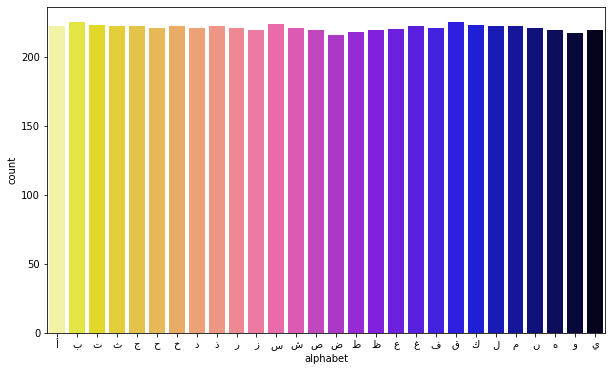

In [9]:
y=pd.DataFrame(y)
y.rename(columns={0:"abc"},inplace=True)

cha_dic={1:"أ", 2:"ب",3:"ت",4:"ث",5:"ج",6:"ح",7:"خ",8:"د",9:"ذ",10:"ر",11:"ز",12:"س",13:"ش",14:"ص",15:"ض",16:"ط",17:"ظ",18:"ع"
,19:"غ",20:"ف",21:"ق",22:"ك",23:"ل",24:"م",25:"ن",26:"ه",27:"و",28:"ي"}

organized=["أ" ,"ب" ,"ت" ,"ث" ,"ج" ,"ح" ,"خ" ,"د" ,"ذ" ,"ر" ,"ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي"]
temp=y.abc.apply(lambda x:cha_dic[x])

plt.figure(figsize=(10,6))
co=sn.countplot(temp,palette="gnuplot2_r",order=organized)
plt.xlabel("alphabet")
plt.show()

# Show examples of the dataset

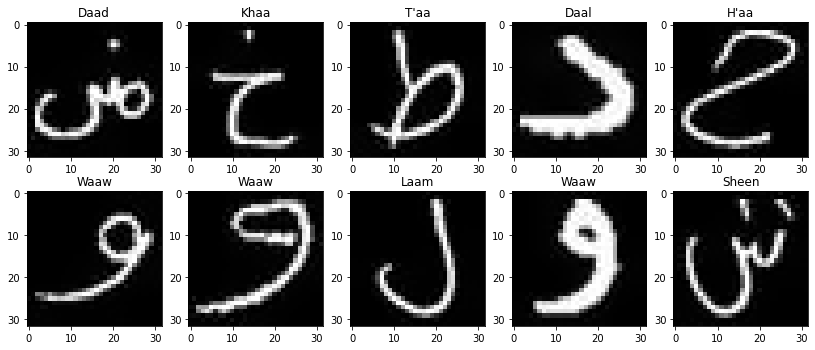

In [10]:
arabic_characters = ['Alef', 'Baa', 'Taa', 'Thaa', 'Jeem', "H'aa", 'Khaa', 'Daal', 'Thaal',
                    'Raa', 'Zaay', 'Seen', 'Sheen', 'Saad', 'Daad', "T'aa", 'Dhaa', 'Ayn',
                    'Ghayn', 'Faa', 'Qaaf', 'Kaaf', 'Laam', 'Meem', 'Noon', 'Haa', 'Waaw', 'Yaa']
y_class = [np.argmax(element) for element in y_train]

plt.figure(figsize=(14,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    x = random.randint(0,len(y_train))
    plt.imshow(x_train[x].reshape(32,32),"gray")
    plt.title(arabic_characters[y_class[x]])
plt.show()

# ANN model

In [11]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32,1)))
model.add(Dense(3000, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(750, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(75, activation='relu'))
model.add(Dense(28, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model.fit(x_train, y_train,validation_data=(x_val,y_val),callbacks=[monitor], epochs=100,verbose=1, batch_size = 32)
accuracy=model.evaluate(x_test,y_test)
accuracy

Train on 6188 samples, validate on 884 samples
Epoch 1/100
6188/6188 [==============================] - 2s 295us/step - loss: 1.7079 - accuracy: 0.4822 - val_loss: 1.0197 - val_accuracy: 0.6708
Epoch 2/100
6188/6188 [==============================] - 1s 193us/step - loss: 0.9323 - accuracy: 0.6994 - val_loss: 0.7606 - val_accuracy: 0.7489
Epoch 3/100
6188/6188 [==============================] - 1s 191us/step - loss: 0.7188 - accuracy: 0.7647 - val_loss: 0.8069 - val_accuracy: 0.7568
Epoch 4/100
6188/6188 [==============================] - 1s 200us/step - loss: 0.5991 - accuracy: 0.8135 - val_loss: 0.6656 - val_accuracy: 0.7851
Epoch 5/100
6188/6188 [==============================] - 1s 192us/step - loss: 0.5190 - accuracy: 0.8366 - val_loss: 0.5916 - val_accuracy: 0.8281
Epoch 6/100
6188/6188 [==============================] - 1s 189us/step - loss: 0.4161 - accuracy: 0.8652 - val_loss: 0.6266 - val_accuracy: 0.8382
Epoch 7/100
6188/6188 [==============================] - 1s 199us/step 

[0.9682826557580162, 0.8489819169044495]

# Saving the model & model's history

In [ ]:
accuracy=round(accuracy[1],5)*100

save_model= str(accuracy)+"AIA9KDS_ANN_"+str(seed)

pickle_out = open(save_model,"wb")
pickle.dump(history, pickle_out) 
pickle_out.close()

model.save(save_model+".h5")

# CNN model

In [12]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(32, 32,1)))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(28, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)


history=model.fit(x_train, y_train,validation_data=(x_val,y_val),callbacks=[monitor], epochs=100,verbose=1, batch_size = 32)
accuracy=model.evaluate(x_test,y_test)
accuracy

Train on 6188 samples, validate on 884 samples
Epoch 1/100
6188/6188 [==============================] - 3s 479us/step - loss: 2.2410 - accuracy: 0.3327 - val_loss: 1.0373 - val_accuracy: 0.7251
Epoch 2/100
6188/6188 [==============================] - 1s 135us/step - loss: 1.1318 - accuracy: 0.6356 - val_loss: 0.6208 - val_accuracy: 0.8314
Epoch 3/100
6188/6188 [==============================] - 1s 148us/step - loss: 0.8121 - accuracy: 0.7343 - val_loss: 0.4259 - val_accuracy: 0.8891
Epoch 4/100
6188/6188 [==============================] - 1s 144us/step - loss: 0.6482 - accuracy: 0.7967 - val_loss: 0.3351 - val_accuracy: 0.9072
Epoch 5/100
6188/6188 [==============================] - 1s 143us/step - loss: 0.5254 - accuracy: 0.8368 - val_loss: 0.2862 - val_accuracy: 0.9084
Epoch 6/100
6188/6188 [==============================] - 1s 140us/step - loss: 0.4636 - accuracy: 0.8559 - val_loss: 0.2363 - val_accuracy: 0.9253
Epoch 7/100
6188/6188 [==============================] - 1s 139us/step 

[0.10477088208624259, 0.9654977321624756]

# Saving the model & model's history

In [ ]:
accuracy=round(accuracy[1],5)*100

save_model= str(accuracy)+"AIA9KDS_"+str(seed)

pickle_out = open(save_model,"wb")
pickle.dump(history, pickle_out) 
pickle_out.close()

model.save(save_model+".h5")

# Loading the model & model's history

In [ ]:
pickle_in= open("97.341AIA9KDS_1","rb")
history=pickle.load(pickle_in)
model=load_model("97.341AIA9KDS_1.h5")
model.evaluate(x_test,y_test)

# Plotting train vs test accuracy & loss

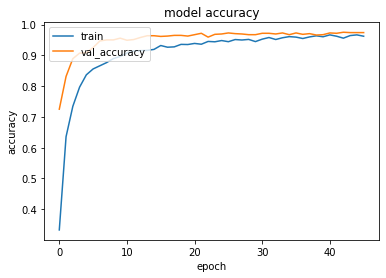

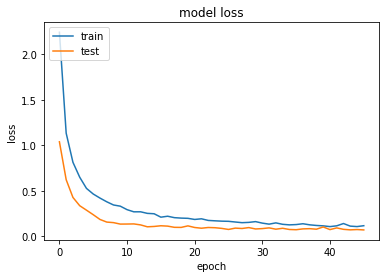

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val_accuracy'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Showing some misclassified images

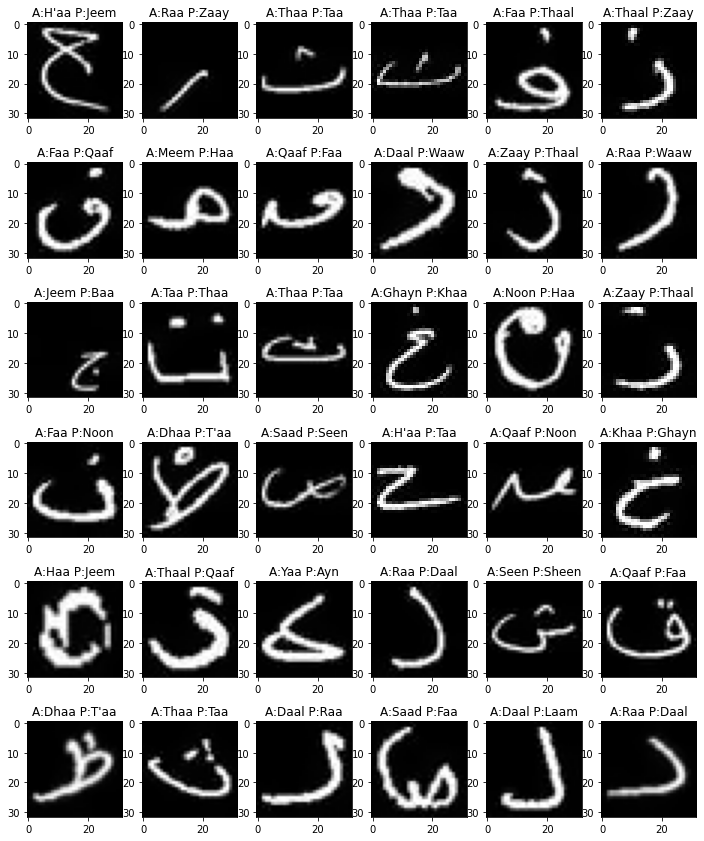

In [14]:
y_pred = model.predict(x_test)
y_classes = [np.argmax(element) for element in y_pred]
y_classes12 = [np.argmax(element) for element in y_test]
y_acutal=[]
y_miss=[]
ind=[]
img=[]
for i in range(len(y_classes12)):
     if y_classes[i] != y_classes12[i]:
        y_acutal.append(y_classes12[i])
        y_miss.append(y_classes[i])
        img.append(x_test[i])

plt.figure(figsize=(12 ,15))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.imshow(img[i],"gray")
    plt.title("A:"+arabic_characters[y_acutal[i]]+" P:"+arabic_characters[y_miss[i]])
plt.show()

# Confusion matrix

<AxesSubplot:>

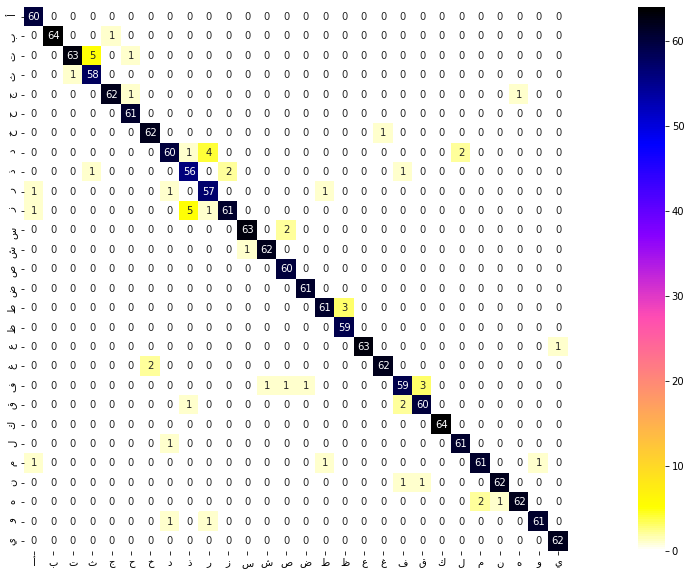

In [15]:
a=confusion_matrix(y_classes, y_classes12)
df_cm = pd.DataFrame(a, index = [i for i in "أبتثجحخدذرزسشصضطظعغفقكلمنهوي"],
                  columns = [i for i in "أبتثجحخدذرزسشصضطظعغفقكلمنهوي"])
plt.figure(figsize = (25,10))
sn.heatmap(df_cm, annot=True,cmap="gnuplot2_r",fmt='g', square=True)

# Classification report

In [16]:
c=classification_report(y_classes, y_classes12, output_dict=True)
df=pd.DataFrame(c).transpose()
df.index=["أ" ,"ب" ,"ت" ,"ث" ,"ج" ,"ح" ,"خ" ,"د" ,"ذ" ,"ر" ,"ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي",'accuracy', 'macro avg', 'weighted avg']
df

,precision,recall,f1-score,support
أ,0.952381,1.000000,0.975610,60.000000
ب,1.000000,0.984615,0.992248,65.000000
ت,0.984375,0.913043,0.947368,69.000000
ث,0.906250,0.983051,0.943089,59.000000
ج,0.984127,0.968750,0.976378,64.000000
ح,0.968254,1.000000,0.983871,61.000000
خ,0.968750,0.984127,0.976378,63.000000
د,0.952381,0.895522,0.923077,67.000000
ذ,0.888889,0.933333,0.910569,60.000000
ر,0.904762,0.950000,0.926829,60.000000
